## Library imports

This section will contain the libraries for the development of the project.

In [987]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multiclass import OneVsRestClassifier


## Initial data exploration

A first review of the dataset will be performed in order to know its general structure, distribution of values and main characteristics. In addition, the quality of the information will be evaluated by detecting missing values, inconsistent data types and possible duplicates.

In [988]:
df = pd.read_csv('cleaned.csv')  

print('\nBasic informations\n')
print(df.info())
print('\nSummary statistics\n')
print(df.describe())
print('\nMissing values\n')
print(df.isnull().sum())
print('\nDuplicated rows : ', df.duplicated().sum())
print()


Basic informations

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2952 entries, 0 to 2951
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Brand                2952 non-null   object 
 1   Product_Description  2952 non-null   object 
 2   Screen_Size          2952 non-null   float64
 3   RAM                  2952 non-null   object 
 4   Processor            2952 non-null   object 
 5   GPU                  2604 non-null   object 
 6   GPU_Type             2718 non-null   object 
 7   Resolution           2565 non-null   object 
 8   Condition            2952 non-null   object 
 9   Price                2952 non-null   float64
dtypes: float64(2), object(8)
memory usage: 230.8+ KB
None

Summary statistics

       Screen_Size        Price
count  2952.000000  2952.000000
mean     14.550237   517.552805
std       1.175322   235.592872
min      10.000000     0.000000
25%      14.000000   325.990000


### Categorical Variables Overview
To better understand categorical variables, we review the Number of unique values and the most frequent categories:

In [989]:
cat_columns = ['Brand', 'RAM', 'Processor', 'GPU', 'GPU_Type', 'Resolution', 'Condition']

for col in cat_columns:
    if col in df.columns:
        print(f'\n{col} - Number of unique values: {df[col].nunique()}')
        print(df[col].value_counts())


Brand - Number of unique values: 25
Brand
Dell         1109
Lenovo        627
HP            578
Microsoft     197
Asus          134
Acer          100
MSI            62
Samsung        61
LG             38
Gateway        13
Panasonic       5
Apple           5
Razer           4
Sony            3
Gigabyte        3
Dell Inc.       2
Chuwi           2
Intel           2
Huawei          1
Getac           1
Google          1
ByteSpeed       1
Eurocom         1
AVITA           1
Ruggon          1
Name: count, dtype: int64

RAM - Number of unique values: 23
RAM
16       1318
8        1185
32        273
4          84
64         47
8GB         7
16gb        6
12          6
8gb         4
up          3
8GB,        3
24          2
40          2
20          2
16GB        2
upto        1
256         1
512         1
4GB         1
64gb        1
32GB        1
Up          1
16GB,       1
Name: count, dtype: int64

Processor - Number of unique values: 48
Processor
Intel Core i5 11th Gen.        450
Intel Co

## Cleaning datas

First, we'll make the data in the processor column usable.

In [990]:
def split_processor(proc):
    parts = proc.split()
    brand = parts[0] if len(parts) > 0 else None
    type_ = ' '.join(parts[1:3]) if len(parts) >= 3 else None
    gen = ' '.join(parts[3:5]) if len(parts) > 3 else None
    return pd.Series([brand, type_, gen])

df[['Processor_Brand', 'Processor_Type', 'Processor_Gen']] = df['Processor'].apply(split_processor)

print(f'\nNumber of unique values: {df[['Processor_Brand']].nunique()}\n')
print(df[['Processor_Brand']].value_counts().head())

print(f'\nNumber of unique values: {df[['Processor_Type']].nunique()}\n')
print(df[['Processor_Type']].value_counts())

print(f'\nNumber of unique values: {df[['Processor_Gen']].nunique()}\n')
print(df[['Processor_Gen']].value_counts())



Number of unique values: Processor_Brand    2
dtype: int64

Processor_Brand
Intel              2893
AMD                  59
Name: count, dtype: int64

Number of unique values: Processor_Type    8
dtype: int64

Processor_Type
Core i5           1386
Core i7           1201
Core i3            285
Ryzen 5             30
Core i9             21
Ryzen 7             15
Ryzen 3              7
Ryzen 9              7
Name: count, dtype: int64

Number of unique values: Processor_Gen    15
dtype: int64

Processor_Gen
11th Gen.        912
12th Gen.        474
8th Gen.         414
10th Gen.        403
13th Gen.        284
6th Gen.         140
7th Gen.          98
4th Gen.          93
9th Gen.          46
7000 Series       34
5th Gen.          29
5000 Series       13
3000 Series        6
4000 Series        3
6000 Series        3
Name: count, dtype: int64


Next, we'll do the same for the GPU column. This is more difficult, as there are several possible entries for the same output. In addition, we'll be looking for the processor brand for integrated GPUs, and have to deal with null values.

In [991]:
def get_gpu_brand(gpu):
    if pd.isna(gpu):
        return None
    return gpu.split()[0]

df['GPU_Brand'] = df['GPU'].apply(get_gpu_brand)
print(f'\nnumber of unique values before processing: {df[['GPU_Brand']].nunique()}\n')
def clean_gpu_brand(raw):
    if pd.isna(raw):
        return None
    first_word = raw.split()[0].lower().replace('(r)', '').replace('®', '').strip()

    mapping = {
        'intel': 'Intel',
        'nvidia': 'NVIDIA',
        'amd': 'AMD',
        'radeon': 'AMD',
        'iris': 'Intel',
        'microsoft': 'Microsoft',
        'integrated': 'Integrated',
        'skylake': 'Intel',
        'invidia': 'NVIDIA',
        'nvdia': 'NVIDIA',
        'i5-8250u': 'Intel'
    }

    return mapping.get(first_word, first_word.title())

df['GPU_Brand'] = df['GPU'].apply(clean_gpu_brand)

def normalize_gpu_type(gpu_type):
    if pd.isna(gpu_type):
        return gpu_type
    
    integrated_keywords = ['Integrated', 'On-Board Graphics', 'Iris', 'Intel UHD', 'Intergrated', 'Intel® UHD Graphics']
    for keyword in integrated_keywords:
        if keyword.lower() in gpu_type.lower():
            return 'Integrated'
    
    return gpu_type

df['GPU_Type'] = df['GPU_Type'].apply(normalize_gpu_type)

def process_gpu_info(row):
    gpu_brand = row['GPU_Brand']
    processor_brand = row['Processor_Brand']
    gpu_type = row['GPU_Type']

    if gpu_brand == 'Integrated':
        return pd.Series({
            'GPU_Brand': processor_brand,
            'GPU_Type': 'Integrated'
        })
    else:
        if gpu_type == 'Integrated':
            return pd.Series({
                'GPU_Brand': processor_brand,
                'GPU_Type': gpu_type 
            })
        else:
            return pd.Series({
                'GPU_Brand': gpu_brand,
                'GPU_Type': gpu_type 
            })

df[['GPU_Brand', 'GPU_Type']] = df.apply(process_gpu_info, axis=1)

df['GPU_Brand'] = df['GPU_Brand'].fillna('Unknown')
df['GPU_Type'] = df['GPU_Type'].fillna('Unknown')

print(f'\nNumber of unique values: {df[['GPU_Brand']].nunique()}')
print(f'\nMissing values {df['GPU_Brand'].isnull().sum()}')
print(df['GPU_Brand'].value_counts())

print(f'\nNumber of unique values: {df[['GPU_Type']].nunique()}')
print(f'\nMissing values {df['GPU_Type'].isnull().sum()}')
print(df['GPU_Type'].value_counts())




number of unique values before processing: GPU_Brand    23
dtype: int64


Number of unique values: GPU_Brand    4
dtype: int64

Missing values 0
GPU_Brand
Intel      2414
NVIDIA      347
Unknown     106
AMD          85
Name: count, dtype: int64

Number of unique values: GPU_Type    3
dtype: int64

Missing values 0
GPU_Type
Integrated            2273
Dedicated Graphics     445
Unknown                234
Name: count, dtype: int64


Next, we can normalize resolution

In [992]:
def normalize_resolution(res):
    if pd.isna(res):
        return 'Unknown'

    res = res.strip()

    match = re.match(r'(\d+)\s*x\s*(\d+)', res)
    if match:
        width = int(match.group(1))
        height = int(match.group(2))

        if width < 100 or height < 100 or width > 8000 or height > 8000:
            return 'Unknown'

        return f'{width} x {height}'
    
    return 'Unknown'

df['Resolution'] = df['Resolution'].apply(normalize_resolution)
top_10_resolutions = df['Resolution'].value_counts().nlargest(10).index

def top_resolution(res):
    if pd.isna(res) or res == '':
        return 'Unknown'
    
    if res in top_10_resolutions:
        return res
    
    return 'Other'

df['Resolution'] = df['Resolution'].apply(top_resolution)

print(f'\nNumber of unique values: {df[['Resolution']].nunique()}')
print(df['Resolution'].value_counts())



Number of unique values: Resolution    11
dtype: int64
Resolution
1920 x 1080    1706
Unknown         401
1920 x 1200     239
1366 x 768      174
Other           167
2560 x 1600      68
2256 x 1504      60
1536 x 1024      47
3840 x 2160      42
1920 x 1280      27
3840 x 2400      21
Name: count, dtype: int64


RAM and Brand columns need also to be cleaned

In [993]:
top_ram = df['RAM'].value_counts().nlargest(1).index
def clean_ram(value):
    if pd.isna(value):
        return 'Unknown'
    
    value_str = str(value).lower().replace('gb', '').replace(',', '').strip()

    try:
        ram_int = int(value_str)
        if 1 <= ram_int <= 64:
            return ram_int
    except ValueError:
        pass
    
    return top_ram[0]

df['RAM'] = df['RAM'].apply(clean_ram)

print(f'\nUnique values: {df["RAM"].nunique()}')
print(df['RAM'].value_counts())

top_10_brands = df['Brand'].value_counts().nlargest(10).index
def top_brand(res):
    if pd.isna(res) or res == '':
        return 'Unknown'
    
    if res in top_10_brands:
        return res
    
    return 'Other'

df['Brand'] = df['Brand'].apply(top_brand)

print(f'\nUnique values: {df["Brand"].nunique()}')
print(df['Brand'].value_counts())

columns_to_delete = ['Product_Description', 'Processor', 'GPU']
df = df.drop(columns=columns_to_delete)


Unique values: 10
RAM
16    1327
8     1199
32     274
4       85
64      48
16       7
12       6
24       2
40       2
20       2
Name: count, dtype: int64

Unique values: 11
Brand
Dell         1109
Lenovo        627
HP            578
Microsoft     197
Asus          134
Acer          100
MSI            62
Samsung        61
LG             38
Other          33
Gateway        13
Name: count, dtype: int64


## Data numerization

In [994]:
columns_to_encode = [
    'Resolution', 'Processor_Type', 'Processor_Gen', 'Condition', 'GPU_Type', 'Brand', 'Screen_Size', 'Processor_Brand', 'GPU_Brand'
]
for column in columns_to_encode:
    df = pd.get_dummies(df, columns=[column], prefix=column)
df.head()


,RAM,Price,Resolution_1366 x 768,Resolution_1536 x 1024,Resolution_1920 x 1080,Resolution_1920 x 1200,Resolution_1920 x 1280,Resolution_2256 x 1504,Resolution_2560 x 1600,Resolution_3840 x 2160,...,Screen_Size_16.1,Screen_Size_17.0,Screen_Size_17.3,Screen_Size_18.0,Processor_Brand_AMD,Processor_Brand_Intel,GPU_Brand_AMD,GPU_Brand_Intel,GPU_Brand_NVIDIA,GPU_Brand_Unknown
0,16,189.99,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,True,False,False
1,64,349.99,False,False,True,False,False,False,False,False,...,False,False,False,False,False,True,False,True,False,False
2,8,369.95,False,False,True,False,False,False,False,False,...,False,False,False,False,False,True,False,True,False,False
3,16,459.00,False,False,True,False,False,False,False,False,...,False,False,False,False,False,True,False,True,False,False
4,16,499.00,False,False,True,False,False,False,False,False,...,False,False,False,False,False,True,False,True,False,False


## Model Training

In [995]:
X = df.drop(columns=['Price'])
y = df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


--- Linear Regression ---
MSE : 26888.35
R² : 0.47
RMSE : 163.9766657130118


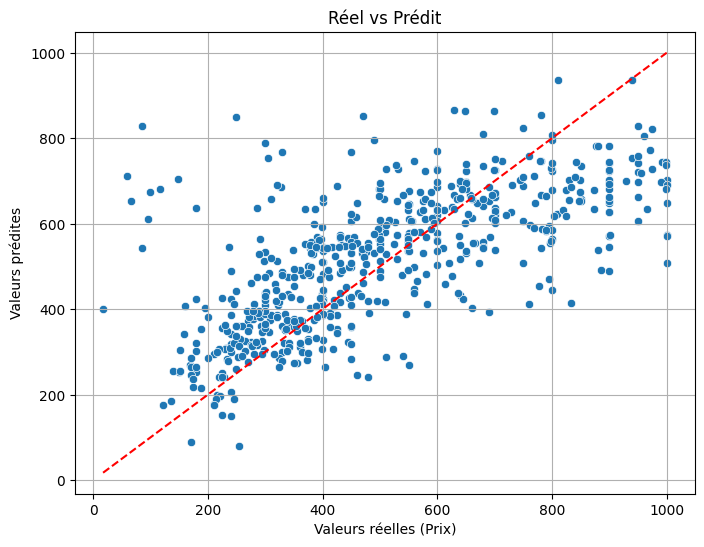

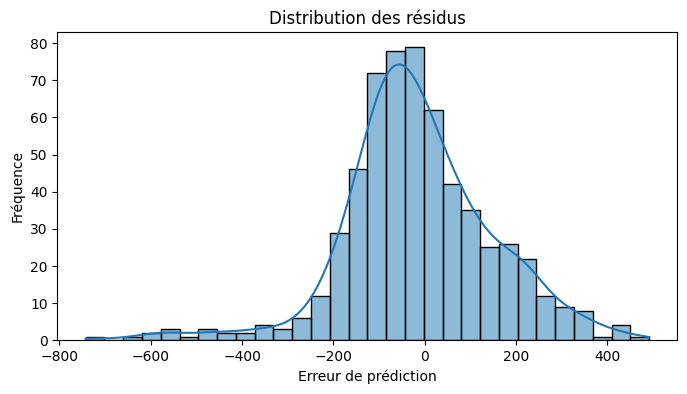

In [996]:
# --- Linear Regression ---
print("\n--- Linear Regression ---")
model = LinearRegression()
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

print(f"MSE : {mean_squared_error(y_test, y_pred):.2f}")
print(f"R² : {r2_score(y_test, y_pred):.2f}")
print(f'RMSE : {np.sqrt(mean_squared_error(y_test, y_pred))}')

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel("Valeurs réelles (Prix)")
plt.ylabel("Valeurs prédites")
plt.title("Réel vs Prédit")
plt.grid(True)
plt.show()

residuals = y_test - y_pred
plt.figure(figsize=(8, 4))
sns.histplot(residuals, bins=30, kde=True)
plt.title("Distribution des résidus")
plt.xlabel("Erreur de prédiction")
plt.ylabel("Fréquence")
plt.show()


--- Random Forest ---
MSE : 24968.83
R² : 0.50
RMSE : 158.01528916401634


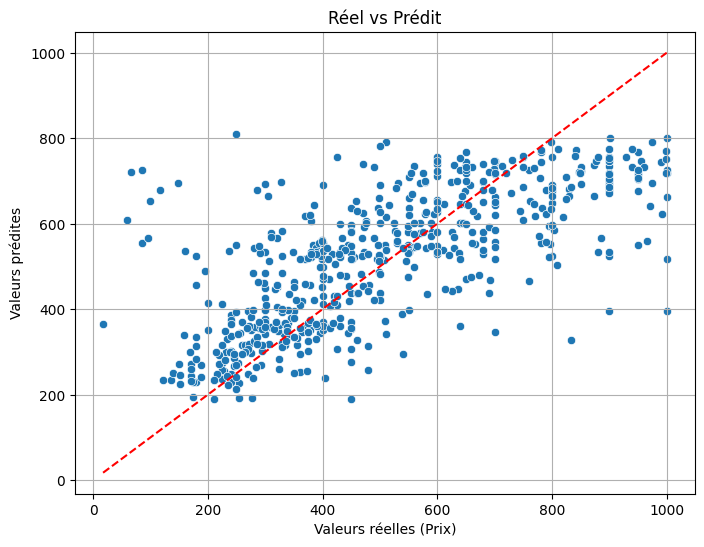

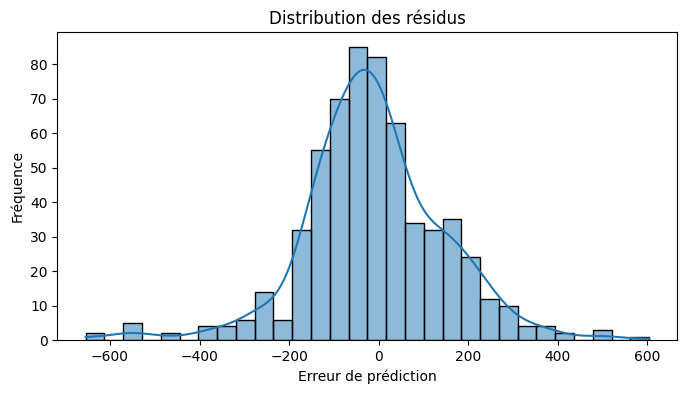

In [997]:
# --- Random Forest ---
print("\n--- Random Forest ---")
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

print(f"MSE : {mean_squared_error(y_test, rf_preds):.2f}")
print(f"R² : {r2_score(y_test, rf_preds):.2f}")
print(f'RMSE : {np.sqrt(mean_squared_error(y_test, rf_preds))}')

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=rf_preds)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel("Valeurs réelles (Prix)")
plt.ylabel("Valeurs prédites")
plt.title("Réel vs Prédit")
plt.grid(True)
plt.show()

residuals = y_test - rf_preds
plt.figure(figsize=(8, 4))
sns.histplot(residuals, bins=30, kde=True)
plt.title("Distribution des résidus")
plt.xlabel("Erreur de prédiction")
plt.ylabel("Fréquence")
plt.show()



--- Gradient Boosting ---
MSE : 25053.22
R² : 0.50
RMSE : 158.28208308107887


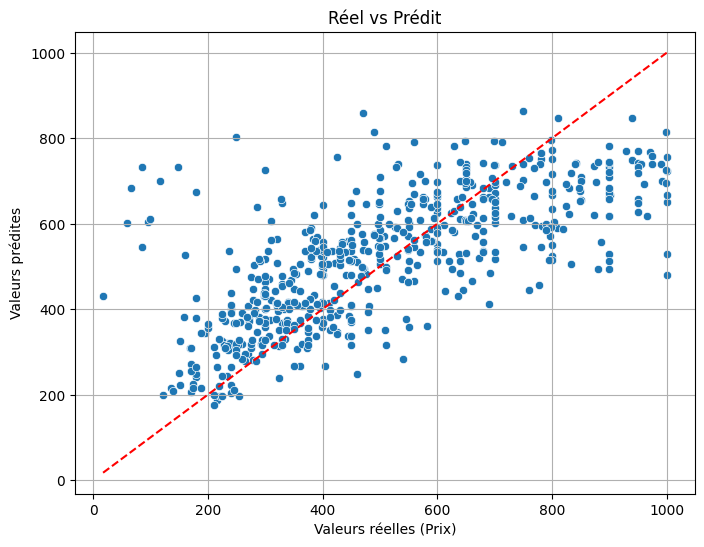

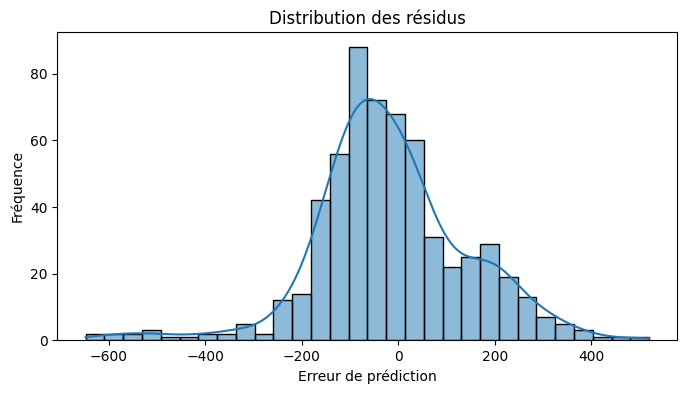

In [998]:
# --- Gradient Boosting ---
print("\n--- Gradient Boosting ---")
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)
gb_preds = gb_model.predict(X_test)

print(f"MSE : {mean_squared_error(y_test, gb_preds):.2f}")
print(f"R² : {r2_score(y_test, gb_preds):.2f}")
print(f'RMSE : {np.sqrt(mean_squared_error(y_test, gb_preds))}')

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=gb_preds)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel("Valeurs réelles (Prix)")
plt.ylabel("Valeurs prédites")
plt.title("Réel vs Prédit")
plt.grid(True)
plt.show()

residuals = y_test - gb_preds
plt.figure(figsize=(8, 4))
sns.histplot(residuals, bins=30, kde=True)
plt.title("Distribution des résidus")
plt.xlabel("Erreur de prédiction")
plt.ylabel("Fréquence")
plt.show()


--- K-NN ---


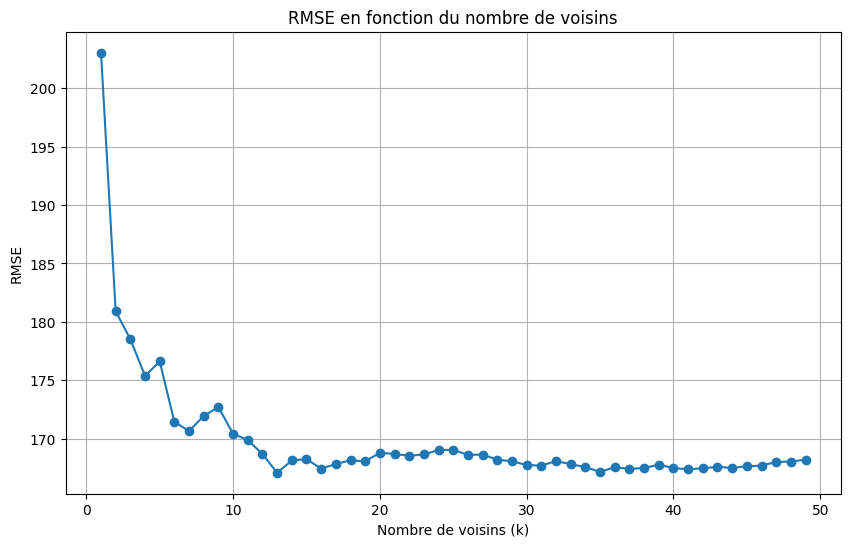


Meilleur k trouvé : 13 avec un RMSE de 167.09

--- K-Nearest Neighbors (k=13) ---
MSE : 27917.85
R² : 0.45
RMSE : 167.08634729475142


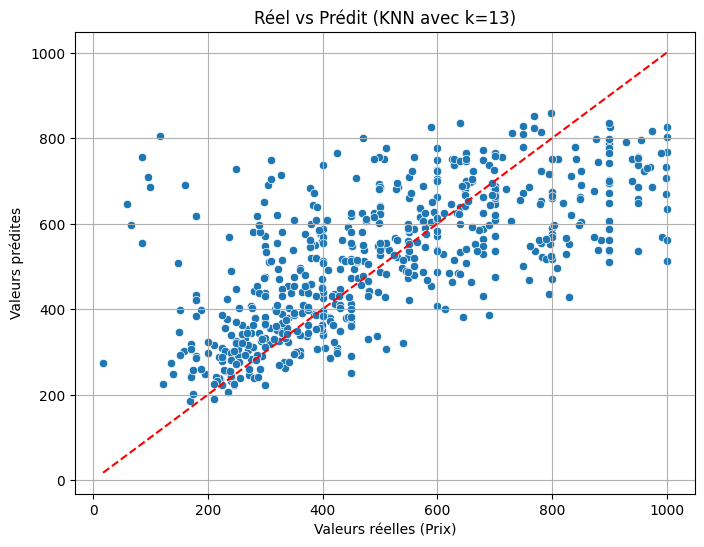

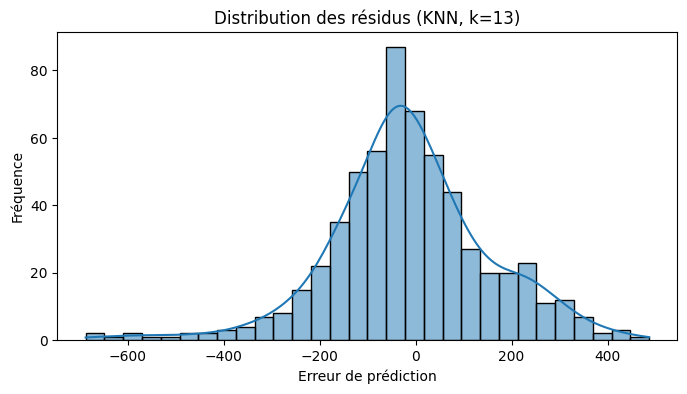

In [999]:
# --- K-Nearest Neighbors ---
print("\n--- K-NN ---")
k_range = range(1, 50)
rmse_scores = []

for k in k_range:
    knn_model = KNeighborsRegressor(n_neighbors=k)
    knn_model.fit(X_train_scaled, y_train)
    knn_preds = knn_model.predict(X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test, knn_preds))
    rmse_scores.append(rmse)

plt.figure(figsize=(10, 6))
plt.plot(k_range, rmse_scores, marker='o')
plt.xlabel('Nombre de voisins (k)')
plt.ylabel('RMSE')
plt.title('RMSE en fonction du nombre de voisins')
plt.grid(True)
plt.show()

best_k = k_range[np.argmin(rmse_scores)]
print(f"\nMeilleur k trouvé : {best_k} avec un RMSE de {min(rmse_scores):.2f}")

knn_best = KNeighborsRegressor(n_neighbors=best_k)
knn_best.fit(X_train_scaled, y_train)
knn_preds = knn_best.predict(X_test_scaled)

print(f"\n--- K-Nearest Neighbors (k={best_k}) ---")
print(f"MSE : {mean_squared_error(y_test, knn_preds):.2f}")
print(f"R² : {r2_score(y_test, knn_preds):.2f}")
print(f'RMSE : {np.sqrt(mean_squared_error(y_test, knn_preds))}')

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=knn_preds)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel("Valeurs réelles (Prix)")
plt.ylabel("Valeurs prédites")
plt.title(f"Réel vs Prédit (KNN avec k={best_k})")
plt.grid(True)
plt.show()

residuals = y_test - knn_preds
plt.figure(figsize=(8, 4))
sns.histplot(residuals, bins=30, kde=True)
plt.title(f"Distribution des résidus (KNN, k={best_k})")
plt.xlabel("Erreur de prédiction")
plt.ylabel("Fréquence")
plt.show()

              precision    recall  f1-score   support

    Low Cost       0.63      0.70      0.66       177
       Moyen       0.59      0.49      0.54       238
        Cher       0.63      0.70      0.66       176

    accuracy                           0.62       591
   macro avg       0.62      0.63      0.62       591
weighted avg       0.62      0.62      0.61       591



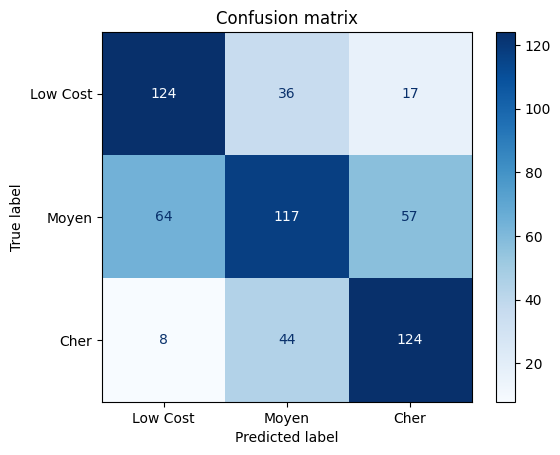

In [1000]:
X = df.drop('Price', axis=1)
y_raw = df['Price']

def price_category(p):
    if p < 350:
        return 0
    elif p < 625:
        return 1
    else:
        return 2

y = y_raw.apply(price_category)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

base_model = LogisticRegression(max_iter=1000)
ovr_model = OneVsRestClassifier(base_model)

ovr_model.fit(X_train, y_train)

y_pred = ovr_model.predict(X_test)

print(classification_report(y_test, y_pred, target_names=["Low Cost", "Moyen", "Cher"]))

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Low Cost", "Moyen", "Cher"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion matrix")
plt.show()

## Exploratory Data Analysis (EDA)
Price distribution